In [20]:
import os
import pandas as pd
import numpy as np

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

import string
import nlp_utils

import matplotlib.pyplot as plt
import seaborn as sns

import re

In [43]:
print(os.listdir('data'))
print(os.listdir())


nltk.download('punkt')
nltk.download('wordnet')

STOPWORDS = set(stopwords.words('english'))

['nlp-getting-started.zip', 'sample_submission.csv', 'test.csv', 'train.csv']
['.ipynb_checkpoints', 'data', 'disaster_tweets.ipynb', 'get_dataset_from_kaggle.py', 'nlp_utils.py', 'word2vec.model', '__pycache__']


[nltk_data] Error loading punkt: <urlopen error [WinError 10054] An
[nltk_data]     existing connection was forcibly closed by the remote
[nltk_data]     host>
[nltk_data] Error loading wordnet: <urlopen error [WinError 10054] An
[nltk_data]     existing connection was forcibly closed by the remote
[nltk_data]     host>


In [44]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
train.describe(include='all')

,id,keyword,location,text,target
count,7613.000000,7552,5080,7613,7613.00000
unique,NaN,221,3341,7503,NaN
top,NaN,fatalities,USA,11-Year-Old Boy Charged With Manslaughter of T...,NaN
freq,NaN,45,104,10,NaN
mean,5441.934848,NaN,NaN,NaN,0.42966
std,3137.116090,NaN,NaN,NaN,0.49506
min,1.000000,NaN,NaN,NaN,0.00000
25%,2734.000000,NaN,NaN,NaN,0.00000
50%,5408.000000,NaN,NaN,NaN,0.00000
75%,8146.000000,NaN,NaN,NaN,1.00000


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [7]:
train.keyword.unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

In [8]:
train.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [69]:
visual_df = train.copy()

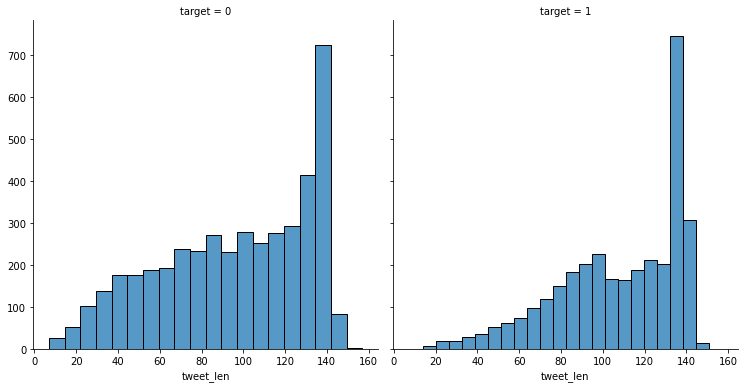

In [77]:
visual_df['tweet_len'] = visual_df['text'].str.len()

g = sns.FacetGrid(visual_df, col='target', height=5.5, aspect=.95)
g.map(sns.histplot, 'tweet_len')

### Working with text

### Make additional features

In [45]:
def make_features(df):
    df_features = df.copy()

    df_features['word_count'] = df_features['text'].apply(lambda x: len(x.split()))
    df_features['unique_word_count'] = df_features['text'].apply(lambda x: len(set(x.split())))

    df_features['hashtag_in_text'] = df_features['text'].apply(lambda x: '#' in x).astype('uint8')
    df_features['mention_in_text'] = df_features['text'].apply(lambda x: '@' in x).astype('uint8')
    df_features['url_in_text'] = df_features['text'].apply(lambda x: 'http' in x).astype('uint8')

    df_features['stopwords_count'] = df_features['text'].apply(lambda x: len([w for w in x.split() if w in STOPWORDS]))

    df_features['hashtag_count'] = df_features['text'].apply(lambda x: x.count('#'))
    df_features['mention_count'] = df_features['text'].apply(lambda x: x.count('@'))
    df_features['url_count'] = df_features['text'].apply(lambda x: x.count('http'))

    df_features['punctuation_count'] = df_features['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

    df_features['!_count'] = df_features['text'].apply(lambda x: x.count('!'))
    df_features['?_count'] = df_features['text'].apply(lambda x: x.count('?'))

    df_features['mean_word_len'] = df_features['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
    
    return df_features

In [46]:
train = make_features(train)
test = make_features(test)

train.head()

,id,keyword,location,text,target,word_count,unique_word_count,hashtag_in_text,mention_in_text,url_in_text,stopwords_count,hashtag_count,mention_count,url_count,punctuation_count,!_count,?_count,mean_word_len
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,13,13,1,0,0,5,1,0,0,1,0,0,4.384615
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,7,7,0,0,0,0,0,0,0,1,0,0,4.571429
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,22,20,0,0,0,9,0,0,0,3,0,0,5.090909
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,8,8,1,0,0,1,1,0,0,2,0,0,7.125000
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,16,15,1,0,0,6,2,0,0,2,0,0,4.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1,11,11,0,0,1,2,0,0,1,5,0,0,6.636364
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,20,17,0,1,0,7,0,2,0,5,0,0,5.300000
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1,8,8,0,0,1,1,0,0,1,11,0,1,7.250000
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,19,19,0,0,0,5,0,0,0,5,0,0,6.263158


### Clean text 

In [47]:
def text_preprocess(tweet): 
            
    # Special characters
    tweet = re.sub(r"\x89Û_", "", tweet)
    tweet = re.sub(r"\x89ÛÒ", "", tweet)
    tweet = re.sub(r"\x89ÛÓ", "", tweet)
    tweet = re.sub(r"\x89ÛÏWhen", "When", tweet)
    tweet = re.sub(r"\x89ÛÏ", "", tweet)
    tweet = re.sub(r"China\x89Ûªs", "China's", tweet)
    tweet = re.sub(r"let\x89Ûªs", "let's", tweet)
    tweet = re.sub(r"\x89Û÷", "", tweet)
    tweet = re.sub(r"\x89Ûª", "", tweet)
    tweet = re.sub(r"\x89Û\x9d", "", tweet)
    tweet = re.sub(r"å_", "", tweet)
    tweet = re.sub(r"\x89Û¢", "", tweet)
    tweet = re.sub(r"\x89Û¢åÊ", "", tweet)
    tweet = re.sub(r"fromåÊwounds", "from wounds", tweet)
    tweet = re.sub(r"åÊ", "", tweet)
    tweet = re.sub(r"åÈ", "", tweet)
    tweet = re.sub(r"JapÌ_n", "Japan", tweet)    
    tweet = re.sub(r"Ì©", "e", tweet)
    tweet = re.sub(r"å¨", "", tweet)
    tweet = re.sub(r"SuruÌ¤", "Suruc", tweet)
    tweet = re.sub(r"åÇ", "", tweet)
    tweet = re.sub(r"å£3million", "3 million", tweet)
    tweet = re.sub(r"åÀ", "", tweet)
    
    # Contractions
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"don\x89Ûªt", "do not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I\x89Ûªm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"you\x89Ûªve", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"it\x89Ûªs", "it is", tweet)
    tweet = re.sub(r"doesn\x89Ûªt", "does not", tweet)
    tweet = re.sub(r"It\x89Ûªs", "It is", tweet)
    tweet = re.sub(r"Here\x89Ûªs", "Here is", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"I\x89Ûªve", "I have", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"can\x89Ûªt", "cannot", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"wouldn\x89Ûªt", "would not", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"That\x89Ûªs", "That is", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"You\x89Ûªre", "You are", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"Don\x89Ûªt", "Do not", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"Can\x89Ûªt", "Cannot", tweet)
    tweet = re.sub(r"you\x89Ûªll", "you will", tweet)
    tweet = re.sub(r"I\x89Ûªd", "I would", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)  
    tweet = re.sub(r"donå«t", "do not", tweet)   
            
    # Character entity references
    tweet = re.sub(r"&gt;", ">", tweet)
    tweet = re.sub(r"&lt;", "<", tweet)
    tweet = re.sub(r"&amp;", "&", tweet)
    
    # Typos, slang and informal abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"amirite", "am I right", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"8/5/2015", "2015-08-05", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"8/6/2015", "2015-08-06", tweet)
    tweet = re.sub(r"10:38PM", "10:38 PM", tweet)
    tweet = re.sub(r"10:30pm", "10:30 PM", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)   
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
           
    # Urls
    
    tweet = nlp_utils.remove_url(tweet)
       
    # Words with punctuations and special characters
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`"
    for p in punctuations:
        tweet = tweet.replace(p, f' {p} ')
        
    # ... and ..
    tweet = tweet.replace('...', ' ... ')
    if '...' not in tweet:
        tweet = tweet.replace('..', ' ... ')      
        
    # Acronyms
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"mÌ¼sica", "music", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)    
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)    
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet)
    tweet = re.sub(r"Suruc", "Sanliurfa", tweet)   
    
    # Grouping same words without embeddings
    tweet = re.sub(r"Bestnaijamade", "bestnaijamade", tweet)
    tweet = re.sub(r"SOUDELOR", "Soudelor", tweet)
    
    tweet = tweet.lower().strip()
    
    
    
    #tweet = word_tokenize(tweet)
    #tweet = [word for word in tweet if word not in STOPWORDS]
    
    stemmer = PorterStemmer()
    tweet = [stemmer.stem(word) for word in tweet.split()]
    
    return ' '.join(tweet)

In [48]:
text_prep = train['text'].copy()
text_prep = text_prep.apply(text_preprocess)

In [49]:
text_prep

0       our deed are the reason of thi # earthquak may...
1                  forest fire near la rong sask . canada
2       all resid ask to ' shelter in place ' are be n...
3       13,000 peopl receiv # wildfir evacu order in c...
4       just got sent thi photo from rubi # alaska as ...
                              ...                        
7608    two giant crane hold a bridg collaps into near...
7609    @ aria_ahrari @ thetawniest the out of control...
7610    m1 . 94 [ 01 : 04 utc ] ? 5km s of volcano haw...
7611    polic investig after an e - bike collid with a...
7612    the latest : more home raze by northern califo...
Name: text, Length: 7613, dtype: object

### Working with keyword column

In [50]:
train['keyword'] = train['keyword'].replace(np.nan, 'notspecified')

keyword = train['keyword']


lemmatizer = WordNetLemmatizer()
lem = [lemmatizer.lemmatize(word) for word in keyword]

stemmer = PorterStemmer()
stem = [stemmer.stem(word) for word in lem]


print("Len before preprocessing: {}".format(train.keyword.unique().shape))
print("Len after preprocessing: {}".format(len(set(stem))))

train['keyword'] = stem

similar_keyword = {'buildings%20burn':'burning%20build', 'buildings%20on%20fir':'burning%20build',
                   'dead':'death', 'demolish':'demolit', 'destroy':'destruct', 'injuri':'injur',
                   'mass%20murder':'mass%20murd', 'nuclear%20reactor':'nuclear%20disast', 'panic':'panick',
                   'rescu':'rescuer', 'survivor':'surviv', 'terrorist':'terror', 'traumatis':'trauma',
                   'wild%20fir':'wildfir'
                  }

for key, value in similar_keyword.items():
    train['keyword'] = train['keyword'].replace(key, value)

print('Final length: {}'.format(train.keyword.unique().shape[0]))

Len before preprocessing: (222,)
Len after preprocessing: 167
Final length: 153


### Make tfidf vector from text

In [51]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(text_prep).toarray()

y = train.target

#vectorizer = CountVectorizer(max_features=n_features)
#X = vectorizer.fit_transform(text_prep).toarray()

to_drop = ['id', 'keyword', 'location', 'text', 'target', 'hashtag_in_text' , 'mention_in_text', 'url_in_text']

X = np.hstack([X, train.drop(to_drop, axis=1), pd.get_dummies(train['keyword'])])

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

print('Constant prediction score: {}'.format(f1_score(np.ones(y_test.shape), y_test)))
print('Train set shape: {}'.format(x_train.shape))

Constant prediction score: 0.5976058931860037
Train set shape: (6090, 14130)


### Building model

In [52]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(x_train, y_train)
pred = log_reg.predict(x_test)
f1_score(pred, y_test)

0.7548701298701299